In [2]:
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 5.4 MB/s eta 0:00:00


In [3]:
!pip install torch

In [52]:
import numpy as np
import pyod as po
from pyod.models.iforest import IForest
from pyod.models.loda import LODA
from pyod.models.dif import DIF
from pyod.utils.utility import standardizer
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from pyod.utils.utility import standardizer
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [61]:
N_SAMPLES_TEST = 500
TEST_LOW = -3.0
TEST_HIGH = 3.0

N_PROJECTIONS = 5
N_BINS = 10
RANDOM_SEED = 42

In [54]:
#ex1
class AnomalyDetector:
    def __init__(self, n_projections=5, n_bins=10, random_state=None):
        self.n_projections = n_projections
        self.n_bins = n_bins
        self.random_state = random_state


        self.unit_vectors_ = None
        self.histogram_data_ = []
        self._rng = np.random.default_rng(random_state)

    def fit(self, X):
        _, n_features = X.shape
        n_samples = X.shape[0]


        random_vectors = self._rng.multivariate_normal(
            mean=np.zeros(n_features),
            cov=np.identity(n_features),
            size=self.n_projections
        )
        norms = np.linalg.norm(random_vectors, axis=1, keepdims=True)
        self.unit_vectors_ = random_vectors / norms


        projected_data_train = X.dot(self.unit_vectors_.T)
        self.histogram_data_ = []

        for i in range(self.n_projections):
            projection_values = projected_data_train[:, i]

            min_val = projection_values.min()
            max_val = projection_values.max()
            padding = (max_val - min_val) * 0.1
            hist_range = (min_val - padding, max_val + padding)

            counts, bin_edges = np.histogram(
                projection_values,
                bins=self.n_bins,
                range=hist_range
            )

            probabilities = counts / n_samples
            self.histogram_data_.append({'probs': probabilities, 'edges': bin_edges})

        return self

    def score(self, X):
        projected_data_test = X.dot(self.unit_vectors_.T)
        sample_probabilities = np.zeros_like(projected_data_test)

        for i in range(self.n_projections):
            hist_info = self.histogram_data_[i]
            probabilities = hist_info['probs']
            bin_edges = hist_info['edges']

            all_sample_values_test = projected_data_test[:, i]

            bin_indices = np.digitize(all_sample_values_test, bin_edges) - 1
            bin_indices_clipped = np.clip(bin_indices, 0, self.n_bins - 1)

            sample_probabilities[:, i] = probabilities[bin_indices_clipped]

        anomaly_scores = np.mean(sample_probabilities, axis=1)
        return anomaly_scores


In [62]:
def generate_training_data():
    X, _ = sk.datasets.make_blobs(
        n_samples=500,
        centers=[[0.0,0.0]],
        cluster_std=2.0,
        n_features=2,
    )
    return X

def generate_test_data():
    X_test = np.random.uniform(
        low=TEST_LOW,
        high=TEST_HIGH,
        size=(N_SAMPLES_TEST, 2)
    )
    return X_test

def plot_scores(X_test, anomaly_scores):
    plt.figure(figsize=(10, 8))

    scatter = plt.scatter(
        X_test[:, 0],
        X_test[:, 1],
        c=anomaly_scores,
        cmap='coolwarm',
        alpha=0.7
    )

    plt.colorbar(scatter, label='Anomaly Score (Mean Probability)')
    plt.title('Test Dataset (Uniform) with Anomaly Scores')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.axis('equal')

    plt.show()


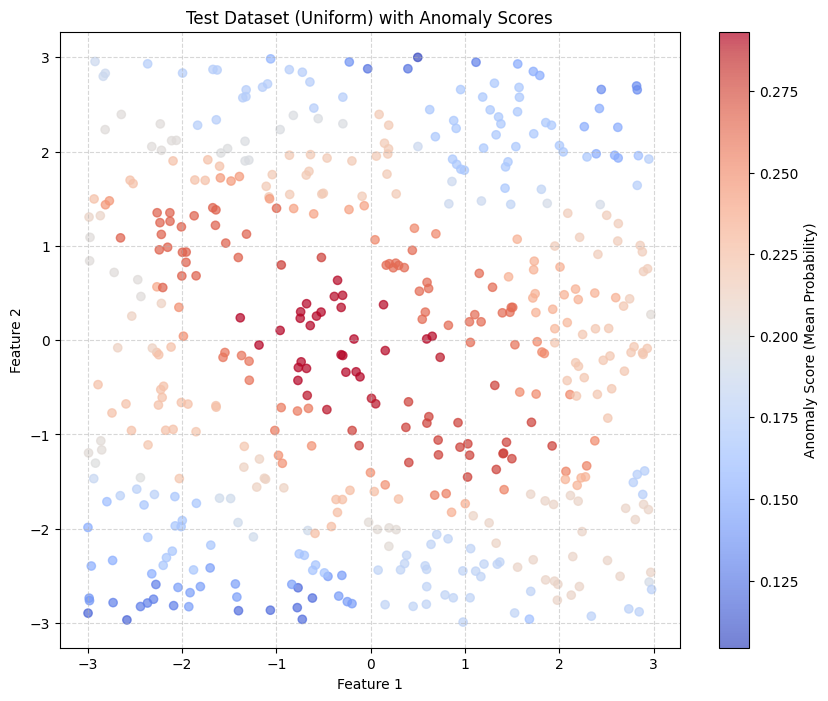

In [63]:
if __name__ == "__main__":
    np.random.seed(RANDOM_SEED)

    X_train = generate_training_data()
    X_test = generate_test_data()

    detector = AnomalyDetector(
        n_projections=N_PROJECTIONS,
        n_bins=N_BINS,
        random_state=RANDOM_SEED
    )

    detector.fit(X_train)

    scores = detector.score(X_test)

    plot_scores(X_test, scores)

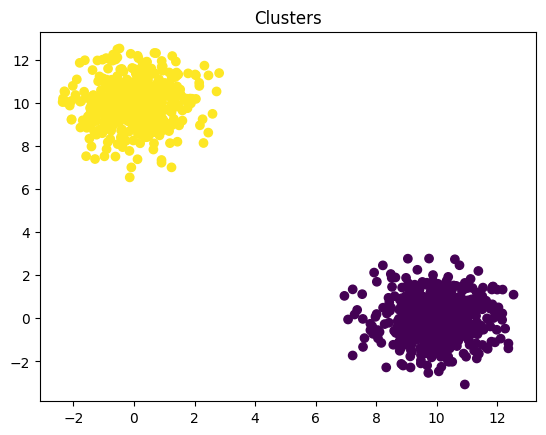

In [6]:
#ex2
X,y = sk.datasets.make_blobs(n_samples=[500,500],cluster_std=[1,1],centers=[(10,0),(0,10)])
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title("Clusters")
plt.show()

In [14]:
iforest = IForest(contamination=0.02)
iforest.fit(X)
Test = np.random.uniform(low=-10,high=20,size=(1000,2))
predict = iforest.decision_function(Test)

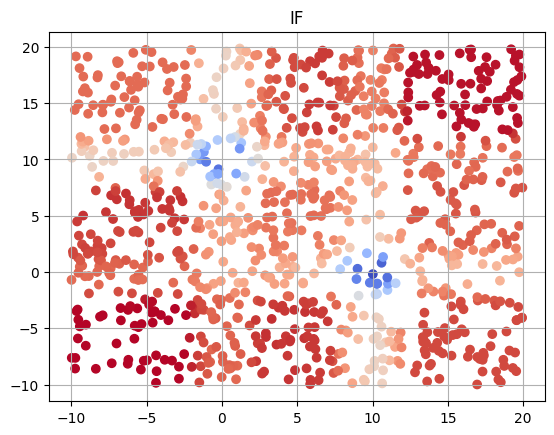

In [17]:
plt.scatter(
    Test[:, 0],
    Test[:, 1],
    c=predict,
    cmap='coolwarm'
)

plt.title("IF")
plt.grid(True)
plt.show()

In [18]:
dif = DIF(hidden_neurons=[100,50],contamination=0.02)
dif.fit(X)
predict = dif.decision_function(Test)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument i

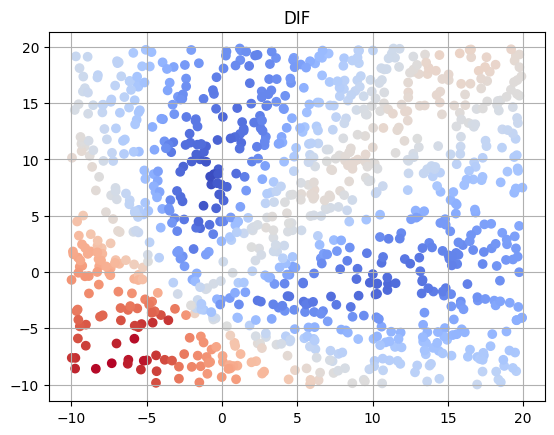

In [20]:
plt.scatter(
    Test[:, 0],
    Test[:, 1],
    c=predict,
    cmap='coolwarm'
)

plt.title("DIF")
plt.grid(True)
plt.show()

In [21]:
loda = LODA(n_bins=10,contamination=0.02) #100,10,40
loda.fit(X)
predict = loda.decision_function(Test)

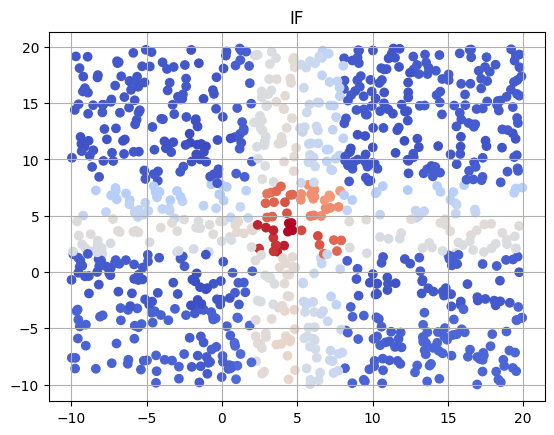

In [22]:
plt.scatter(
    Test[:, 0],
    Test[:, 1],
    c=predict,
    cmap='coolwarm'
)

plt.title("IF")
plt.grid(True)
plt.show()

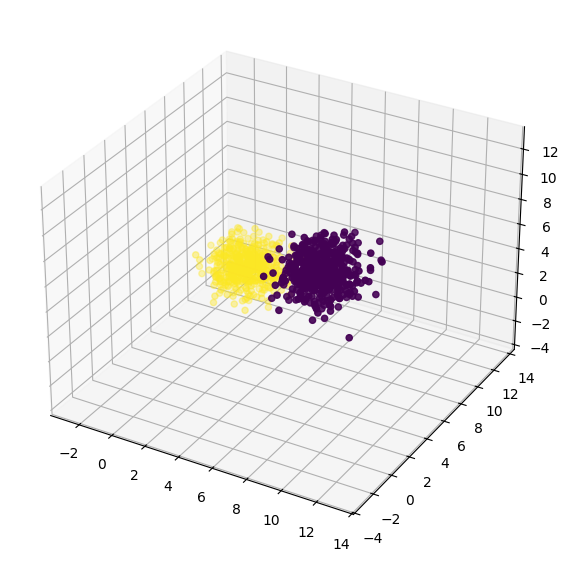

In [32]:
#3D
X,y = sk.datasets.make_blobs(n_samples=[500,500], n_features=3,cluster_std=[1,1],centers=[(10,0,10),(0,10,0)])

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)

In [35]:
iforest = IForest(contamination=0.02)
iforest.fit(X)
Test = np.random.uniform(low=-10,high=20,size=(1000,3))
predict = iforest.decision_function(Test)

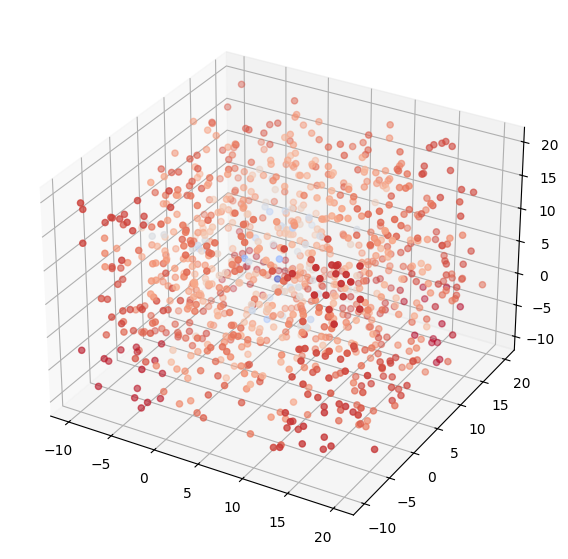

In [36]:
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Test[:, 0], Test[:, 1], Test[:, 2], c=predict, cmap = 'coolwarm')

In [37]:
dif = DIF(hidden_neurons=[100,50],contamination=0.02)
dif.fit(X)
predict = dif.decision_function(Test)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument i

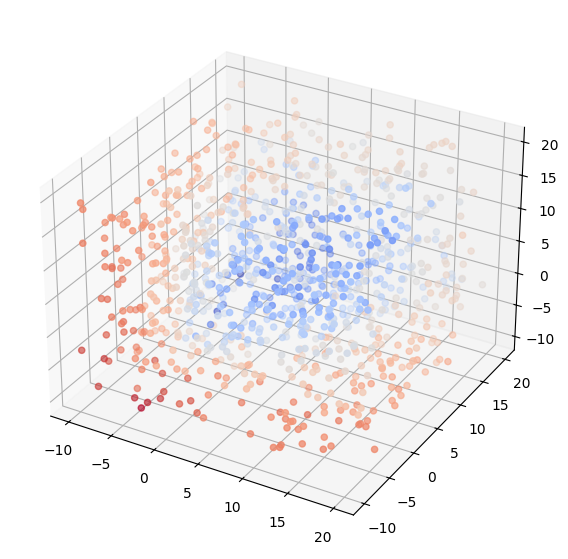

In [38]:
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Test[:, 0], Test[:, 1], Test[:, 2], c=predict, cmap = 'coolwarm')

In [41]:
loda = LODA(n_bins=40,contamination=0.02) #100,10,40
loda.fit(X)
predict = loda.decision_function(Test)

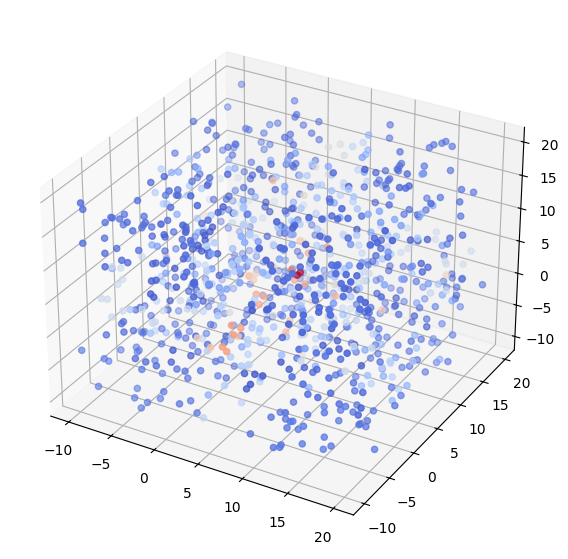

In [42]:
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Test[:, 0], Test[:, 1], Test[:, 2], c=predict, cmap = 'coolwarm')

In [64]:
#ex3
def run_experiment():
    data = loadmat('shuttle.mat')
    X = data['X']
    y = data['y'].ravel()

    results = {
        'IForest': {'BA': [], 'ROC_AUC': []},
        'LODA': {'BA': [], 'ROC_AUC': []},
        'DIF': {'BA': [], 'ROC_AUC': []}
    }

    n_runs = 10

    for i in range(n_runs):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=0.4,
            random_state=i,
            stratify=y
        )


        scaler = StandardScaler()
        X_train_norm = scaler.fit_transform(X_train)
        X_test_norm = scaler.transform(X_test)


        contamination = np.mean(y_train)
        if contamination == 0:
             contamination = 'auto'

        models = {
            'IForest': IForest(contamination=contamination, random_state=i),
            'LODA': LODA(),
            'DIF': DIF(random_state=i)
        }



        for name, model in models.items():

            model.fit(X_train_norm)



            y_pred = model.predict(X_test_norm)



            y_scores = model.decision_function(X_test_norm)


            if name == 'IForest':
                y_pred = np.where(y_pred == -1, 1, 0)

                y_scores = -y_scores


            ba = balanced_accuracy_score(y_test, y_pred)

            roc_auc = roc_auc_score(y_test, y_scores)



            results[name]['BA'].append(ba)
            results[name]['ROC_AUC'].append(roc_auc)

    print("\n--- Mean Results over 10 Runs (Mean ± Standard Dev) ---")
    print(f"{'Model':<10} | {'Balanced Accuracy':<25} | {'ROC AUC':<25}")
    print("-" * 64)

    for name, metrics in results.items():
        ba_mean = np.mean(metrics['BA'])
        ba_std = np.std(metrics['BA'])
        roc_mean = np.mean(metrics['ROC_AUC'])
        roc_std = np.std(metrics['ROC_AUC'])

        print(f"{name:<10} | {ba_mean:.4f} ± {ba_std:.4f}{' ':<13} | {roc_mean:.4f} ± {roc_std:.4f}")

if __name__ == "__main__":
    run_experiment()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument i


--- Mean Results over 10 Runs (Mean ± Standard Dev) ---
Model      | Balanced Accuracy         | ROC AUC                  
----------------------------------------------------------------
IForest    | 0.5000 ± 0.0000              | 0.0031 ± 0.0010
LODA       | 0.6028 ± 0.1399              | 0.5743 ± 0.2645
DIF        | 0.5188 ± 0.0047              | 0.9704 ± 0.0064
